In [1]:
import numpy as np
import scipy.linalg as lin
import matplotlib.pyplot as plt
from scipy import sparse

**Exercises 1 and 2**

In [2]:
def jacobi_method(A, b, tol=1e-8, maxiter=100, plot=False):
    
    err = 1e3
    iterate = 0
    
    D = np.diag(A)
    L = np.tril(A)
    U = np.triu(A)
    
    x = np.ones_like(b)
    errs = np.empty(maxiter)
    
    while err > tol and iterate < maxiter:
        x_tilde = x + (b - A @ x) / D
        errs[iterate] = lin.norm(x_tilde - x, np.inf)
        err = errs[iterate]
        iterate += 1
        x = x_tilde
        
    if iterate < maxiter:
        print(f'Number of iterations: {iterate}')
        
    if plot:
        plt.plot(range(1, iterate + 1), errs[:iterate])
        plt.semilogy()
        plt.xlim(1, iterate)
        plt.title('Covergence of Jacobi Method')
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.show()
        
    return x

In [3]:
def diag_dom(n, num_entries=None):
    '''Generate a strictly diagonally dominant (n, n) matrix.
    
    Parameters:
        n (int): The dimension of the system.
        num_entries (int): The number of nonzero values.
            Defaults to n^(3/2)-n.
            
    Returns:
        A ((n,n) ndarray): A (n, n) strictly diagonally dominant matrix.
    '''
    if num_entries is None:
        num_entries = int(n**1.5) - n
    A = np.zeros((n,n))
    rows = np.random.choice(np.arange(0,n), size=num_entries)
    cols = np.random.choice(np.arange(0,n), size=num_entries)
    data = np.random.randint(-4, 4, size=num_entries)
    for i in range(num_entries):
        A[rows[i], cols[i]] = data[i]
    for i in range(n):
        A[i,i] = np.sum(np.abs(A[i])) + 1
    return A

In [4]:
n = 5000
A = diag_dom(n)
b = np.random.random(n)

Number of iterations: 15


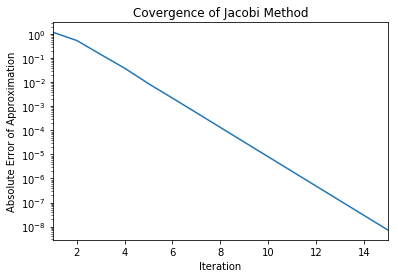

In [5]:
x_opt = jacobi_method(A, b, plot=True)

In [6]:
# Test
np.allclose(A @ x_opt, b, atol=1e-6)

True

**Exercise 3**

In [7]:
def gauss_seidel_method(A, b, tol=1e-8, maxiter=100, plot=False):
    
    err = 1e3
    iterate = 0
    
    x = np.ones_like(b)
    x_tilde = x.copy()
    errs = np.empty(maxiter)
    
    while err > tol and iterate < maxiter:
        for i in range(len(x)):
            x_tilde[i] = x_tilde[i] + (1 / A[i, i]) * \
            (b[i] - A[i, :].T @ x_tilde)  
        
        errs[iterate] = lin.norm(x_tilde - x, np.inf)
        err = errs[iterate]
        iterate += 1
        x = x_tilde.copy()
        
    if iterate < maxiter:
        print(f'Number of iterations: {iterate}')
        
    if plot:
        plt.plot(range(1, iterate + 1), errs[:iterate])
        plt.semilogy()
        plt.xlim(1, iterate)
        plt.title('Covergence of Gauss-Seidel Method')
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.show()
        
    return x

Number of iterations: 10


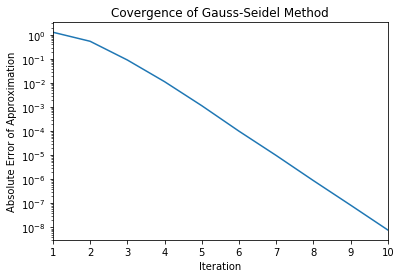

In [8]:
x_opt = gauss_seidel_method(A, b, plot=True) # Recall A uses diag_dom()

In [9]:
np.allclose(A @ x_opt, b, atol=1e-6)

True

**Exercise 4**

In [10]:
def gauss_seidel_sparse(A, b, tol=1e-8, maxiter=100):
    
    err = 1e3
    iterate = 0
    
    x = np.ones_like(b)  # Initial guess
    x_tilde = x.copy()
    errs = np.empty(maxiter)
    
    while err > tol and iterate < maxiter:
        for i in range(len(x)):
            # Code to bypass serious runtime issue ↓
            
            # Get the indices of where the i-th row of A starts and ends if the
            # nonzero entries of A were flattened.
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]

            # Multiply only the nonzero elements of the i-th row of A with the
            # corresponding elements of x.
            Aix = A.data[rowstart:rowend] @ x[A.indices[rowstart:rowend]]
            x_tilde[i] = x_tilde[i] + (1 / A[i, i]) * (b[i] - Aix)  
        
        errs[iterate] = lin.norm(x_tilde - x, np.inf)
        err = errs[iterate]
        iterate += 1
        x = x_tilde.copy()
        
    if iterate < maxiter:
        print(f'Number of iterations: {iterate}')
    else:
        print('No convergence')
        
    return x

In [11]:
A_sparse = sparse.csr_matrix(diag_dom(500))
b_sparse = np.random.random(500)

In [12]:
x_opt = gauss_seidel_sparse(A_sparse, b_sparse)
np.allclose(A_sparse @ x_opt, b_sparse)

Number of iterations: 16


True

**Exercise 5**

In [13]:
def SOR(A, b, ω, tol=1e-8, maxiter=100, plot=False, print_flag=True):
    
    err = 1e3
    iterate = 0
    
    x = np.ones_like(b)
    x_tilde = x.copy()
    errs = np.empty(maxiter)
    
    while err > tol and iterate < maxiter:
        for i in range(len(x)):
            x_tilde[i] = x_tilde[i] + (ω / A[i, i]) * (b[i] - A[i, :].T @ x_tilde)  
        
        errs[iterate] = lin.norm(x_tilde - x, np.inf)
        err = errs[iterate]
        iterate += 1
        x = x_tilde.copy()
        
    if print_flag:
        if iterate < maxiter:
            print(f'Number of iterations: {iterate}')
        else:
            print('No convergence')
        
    return x, iterate, iterate < maxiter

In [14]:
SOR(A, b, 1.3)

Number of iterations: 24


(array([0.00591776, 0.00426838, 0.00737274, ..., 0.00593708, 0.0019121 ,
        0.00436539]), 24, True)

**Exercise 6**

In [15]:
def SOR_q6(n, ω, tol=1e-8, maxiter=100, plot=False, print_flag=True):
    
    A = -4 * np.eye(n ** 2) + np.eye(n ** 2, k=1) + \
        np.eye(n ** 2, k=-1) + np.eye(n ** 2, k=-n) + np.eye(n ** 2, k=n)
    b = np.zeros(n)
    b[0] = -100
    b[-1] = -100
    b = np.tile(b, n)
    
    u, iterations, converged = SOR(A, b, ω, tol, maxiter, False, print_flag)
    u = u.reshape(n, n)

    if plot:
        plt.pcolormesh(u, cmap='coolwarm')
        plt.show()
        
    return u, iterations, converged

Number of iterations: 451


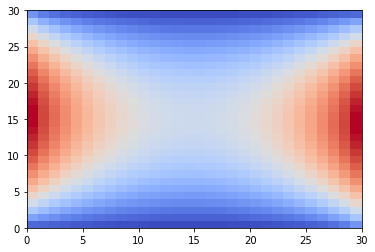

(array([[ 134.02465574,  130.9814848 ,  120.24936797,  109.03609888,
           99.00191119,   90.39485352,   83.12055297,   77.02472135,
           71.96523516,   67.82680577,   64.52050884,   61.980108  ,
           60.15846946,   59.02486508,   58.56326916,   58.77161295,
           59.66199409,   61.26194442,   63.61702607,   66.7952928 ,
           70.89461515,   76.05473257,   82.47763479,   90.46363161,
          100.47923727,  113.29524983,  130.29523269,  154.2430307 ,
          191.42612253,  258.36507806],
        [ 305.11713816,  269.65191549,  240.97988819,  216.89311637,
          196.57669236,  179.45694993,  165.06263702,  153.01309727,
          143.00941354,  134.82147906,  128.27512161,  123.24145369,
          119.62890477,  117.37772168,  116.45659863,  116.86118854,
          118.61441899,  121.76875752,  126.41086706,  132.66952999,
          140.72843522,  150.84668034,  163.39217499,  178.89765437,
          198.15806763,  222.40652937,  253.64265024,  295.2507

In [16]:
SOR_q6(30, 1.8, maxiter=500, plot=True)

**Exercise 7**

In [17]:
ω_s = np.linspace(1, 1.95, 20)
iterate_n = np.nan * np.ones_like(ω_s)
n = 20

for i, ω in enumerate(ω_s):
    result = SOR_q6(n, ω, tol=1e-2, maxiter=1000, print_flag=False)
    if result[2]:
        iterate_n[i] = result[1]

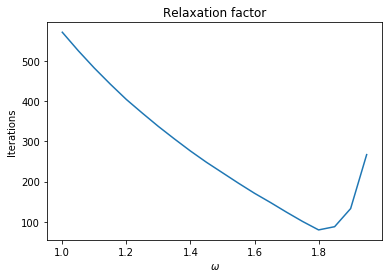

In [18]:
plt.plot(ω_s, iterate_n)
plt.xlabel('$\omega$')
plt.ylabel('Iterations')
plt.title('Relaxation factor')
plt.show()

In [19]:
ω_s[iterate_n.argmin()]

1.7999999999999998